In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ucimlrepo import fetch_ucirepo 
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# fetch dataset 
ionosphere = fetch_ucirepo(id=52) 

# data (as pandas dataframes) 
X = ionosphere.data.features.to_numpy()
y = ionosphere.data.targets.to_numpy() 

'''Inspect dataset''';
#print(ionosphere.metadata) 
#print(ionosphere.variables) 

In [3]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx.reshape(1,), X_pool[query_idx].reshape(1, -1)

In [4]:
active_learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling
)

passive_learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=random_sampling
)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
def benchmark(learner, X_train, X_test, y_train, y_test, n_queries):
    
    scores = []

    for index in range(n_queries):

        query_index, query_instance = learner.query(X_train)

        # Teach our ActiveLearner model the record it has requested.
        X, y = X_train[query_index].reshape(1, -1), y_train[query_index].reshape(1, )
        learner.teach(X=X, y=y)

        # Remove the queried instance from the unlabeled pool.
        X_train, y_train = np.delete(X_train, query_index, axis=0), np.delete(y_train, query_index)

        # Calculate and report our model's accuracy.
        model_accuracy = learner.score(X_test, y_test)
        
        scores.append(model_accuracy)
        
    return scores



In [7]:
n_samples = 50

In [8]:
AL_score = benchmark(active_learner, X_train, X_test, y_train, y_test, n_samples)

In [9]:
PL_score = benchmark(passive_learner, X_train, X_test, y_train, y_test, n_samples)

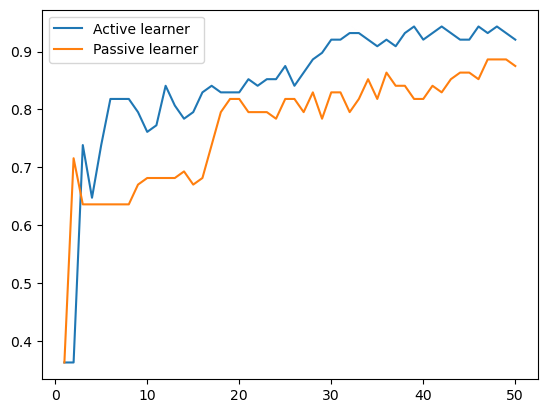

In [10]:
xs = np.arange(1, n_samples + 1)

plt.plot(xs, AL_score, label='Active learner')
plt.plot(xs, PL_score, label='Passive learner')

plt.legend()

plt.show()